<h1>Finetune BERT-base Using PyTorch for Sentiment Analysis </h1>

<img src="https://github.com/Nitesh0406/-Fine-Tuning-BERT-base-for-Sentiment-Analysis./blob/main/BERT.jpg?raw=1" alt="huggingface" style="width:1000px;height:400px;">

## Contents
* Overview
* Approach
* Web Scraping
* Basic Analysis on Scraped Data
* Rating to Sentiment Conversion
* BERT Tokenizer
* Train-Test Split
* Preparation Training Pipeline
* Model Architecture for Sentiment Analysis
* Training Model Using Pytorch
* Evaluating Performance on Test Data
* Testing Model Performance for New Data


# Overview

BERT stands for Bidirectional Encoder Representations from Transformers. It is state of the art NLP technique for a variety of applications such as Name Entity Recognition, Text classification, Question and Answering and many more. BERT was developed by Google Research team and made it public in October 2018. The backbone of BERTs amazing performance is Attention Heads which is borrowed from a previously developed transformer model. Attention Heads allows the model to understand the contextual information hidden inside the data and generates Embedding vectors accordingly.


The main aim of this blog is not to explain the internals of BERT rather it is concentrated on its implementation for Sentiment Analysis. 

I hardly recommend the reader to please visit this [blog1](http://jalammar.github.io/illustrated-transformer/), [blog2](http://jalammar.github.io/illustrated-bert/) and this [blog3](https://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/) which is written by Jay Alammar to understand the internals of the BERT model so that you can relate its application for sentiment analysis.



# Approach
* First we will acquire a dataset using google_play_scraper a python library that provides APIs to scrape data such as review , rating , app description ,app id etc for google play application. We will be focusing on reviews and corresponding ratings to fine tune our BERT model.

* Data cleaning is not required in this case because we will get a decent review data and any way BERT tokenizer can handle punctuations and misspell words.

* Then we will quickly prepare training and test data and will train the model using pytorch.


# Import required Library

In [ ]:
import torch
import torchvision
import torch.nn as nn
import transformers
from transformers import BertModel
from torch.utils.data import Dataset, DataLoader
import numpy as np

import json
import pandas as pd
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from pygments import highlight
from pygments.lexers import JsonLexer
from pygments.formatters import TerminalFormatter

from google_play_scraper import Sort, reviews, app

%matplotlib inline
%config InlineBackend.figure_format='retina'
import warnings
warnings.filterwarnings('ignore')

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

In [ ]:
## Setting up some global variable

COLORS = ['#01BEFE','#FFDD00','#FF7D00','#FF006D','#ADFF02','#8F00FF']
from torch.utils import data
sns.set_palette(sns.color_palette(COLORS))
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
fig_size = (10,7)


# Web Scraping
### App ids
I am building a general purpose sentiment predicting model which is not oriented towards a particular domain like the medical or finance field. Below is the list of 15 application ids which are general purpose use case applications so it is expected that its reviews will be in the form of those languages that we use in our day to day life.


In [ ]:
# 15 applications
## https://play.google.com/store/apps/details?id= application_id
# you can visit the above link with any of the below app id to see the contents of that application. 
app_packages = [
  'com.anydo',
  'com.todoist',
  'com.ticktick.task',
  'com.habitrpg.android.habitica',
  'cc.forestapp',
  'com.oristats.habitbull',
  'com.levor.liferpgtasks',
  'com.habitnow',
  'com.microsoft.todos',
  'prox.lab.calclock',
  'com.gmail.jmartindev.timetune',
  'com.artfulagenda.app',
  'com.tasks.android',
  'com.appgenix.bizcal',
  'com.appxy.planner'
]

### Get reviews 

we have a total five ratings 1 to 5, these ratings are highly imbalanced in the app store. Most of the reviews for most of the application is highly partial toward the higher rating that's why while scaping review data we will filter by score and count so that we would get balanced data for model training.

* rating 1,2 will be assigned as negative.
* rating 3 will be assigned as neutral.
* rating 4,5 will be assigned as positive.

we will scrape 200 reviews for each sentiment for each app.


In [ ]:
## app_reviews is list of json files.
app_reviews = []

for app_id in tqdm(app_packages):
    for score in range(1,6):
        for review_status in [Sort.MOST_RELEVANT , Sort.NEWEST]:
            rv,_ = reviews(app_id              # google_play_scaper has a module caled reviews that returns
                           ,lang='en'          # app_id,content,review_id,score etc. we can control the 
                           ,country='us'       # scraping by changing variable such as sort,count,filter_score_with etc.
                           ,sort=review_status #
                           ,count =  200 if score == 3 else 100
                           ,filter_score_with=score)

            for r in rv:
                r['app_id'] = app_id     # we are adding two more  columns app_id and review_status.
                r['review_status'] = 'most_relevent' if review_status==Sort.MOST_RELEVANT else 'newest'
            app_reviews.extend(rv)
print(len(app_reviews))

100%|██████████| 15/15 [01:25<00:00,  5.70s/it]

16405


In [ ]:
## Get information about app
def json_formatting(obj):
    '''
    This function formates dictionary into json (just for reading purpose)
    '''
    json_object = json.dumps(obj , indent=3, sort_keys= True , default=str)
    print(highlight(json_object , JsonLexer() , TerminalFormatter()))

json_formatting(app_reviews[0])

{
   "app_id": "com.anydo",
   "at": "2021-02-26 09:47:49",
   "content": "Very very bad experience with the management! I have had no response at all what so ever from Any.do to my asking for help with my Apps for malfunction over the last 4 months for my Premium account which I have paid for. Even worse is there is no clear way to terminate of my payment for the Premium service of the Apps which I have expected for. That's why I am asking for help here hoping that the managment team would see this message and give me some help to solve the problem!",
   "repliedAt": "2021-02-28 15:06:51",
   "replyContent": "Hi Kelvin, we've checked our records and could see that you have just reached our to our team, with no previous queries submitted from your account. We always do our best to reply to all queries in a timely manner, and will be more than happy to help you and get to the bottom of any issue :) We're looking forward to your reply, so we can assist!",
   "reviewCreatedVersion": "5.10

The blue font represent keys and yellow font represent values. Our important feature will be 'content' and 'score'. 

##### Lets convert this list of dict into DataFrame and save this as csv file

In [ ]:
reviews_df = pd.DataFrame(app_reviews)
reviews_df.head(2)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,app_id,review_status
0,gp:AOqpTOHTeNGxl9Zhlz-BM6ybraEsnVg0BLDubF8E_fQ...,kelvin ho,https://play-lh.googleusercontent.com/-rSnBD4Y...,Very very bad experience with the management! ...,1,4,5.10.0.8,2021-02-26 09:47:49,"Hi Kelvin, we've checked our records and could...",2021-02-28 15:06:51,com.anydo,most_relevent
1,gp:AOqpTOH2VEhd1ldAR1zxGzjJEIa37fCBgY9S3sqe_TE...,Matt Van Der Schyff,https://play-lh.googleusercontent.com/-sMd4wLr...,originally gave this a 2 star but I think it o...,1,80,5.9.0.2,2021-02-04 11:05:28,We are unaware of any issues with setting remi...,2021-02-04 14:38:06,com.anydo,most_relevent


In [ ]:
# if you want to save data frame
# reviews_df.to_csv('review.csv',header=True,index=False)

reviews_df.shape

(16405, 12)

### Analyse distribution of score

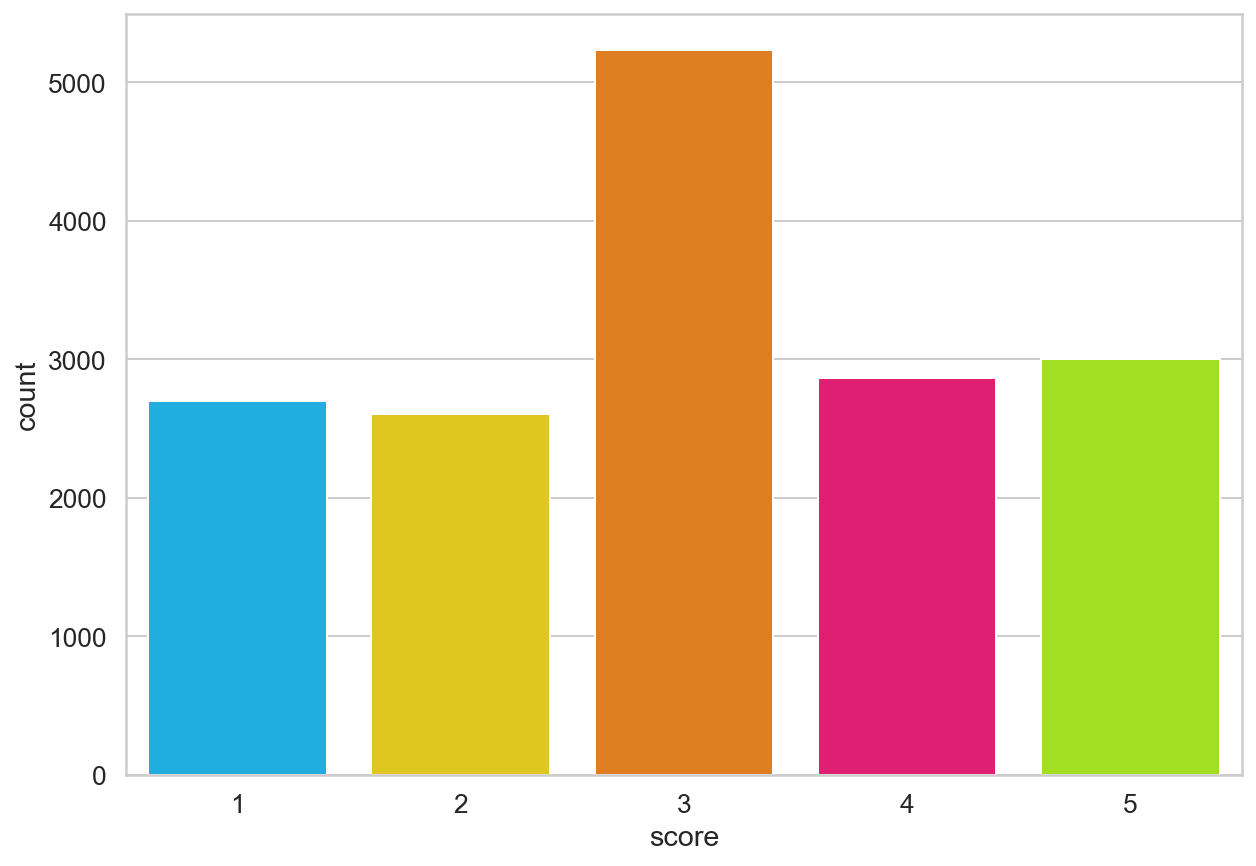

In [ ]:
plt.figure(figsize=fig_size)
sns.countplot(reviews_df.score)
plt.xlabel('score')
plt.show()

We will merge togather the data for score = 1 and 2 and score = 4 and 5 . So in this way we scapped a balanced data set.

Now let's perform this merging on review data frame. Data with score = 1 and 2 will be merged together and assign sentiment value = 0 which will represent the negative sentiment. Data with score = 3 will be assigned with sentiment value = 1 which represent Neutral sentiment and finally Data with score = 4 and 5 will be merged together and assign sentiment value = 2 which represent positive sentiment.

In [ ]:
def get_sentiment(score):
    if score<=2:
        return 0 # negative sentiment
    elif score==3:
        return 1 # neutral sentiment
    else:
        return 2 # positive sentiment
    

reviews_df['sentiment'] = reviews_df.score.apply(get_sentiment)
reviews_df.head(2)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,app_id,review_status,sentiment
0,gp:AOqpTOHTeNGxl9Zhlz-BM6ybraEsnVg0BLDubF8E_fQ...,kelvin ho,https://play-lh.googleusercontent.com/-rSnBD4Y...,Very very bad experience with the management! ...,1,4,5.10.0.8,2021-02-26 09:47:49,"Hi Kelvin, we've checked our records and could...",2021-02-28 15:06:51,com.anydo,most_relevent,0
1,gp:AOqpTOH2VEhd1ldAR1zxGzjJEIa37fCBgY9S3sqe_TE...,Matt Van Der Schyff,https://play-lh.googleusercontent.com/-sMd4wLr...,originally gave this a 2 star but I think it o...,1,80,5.9.0.2,2021-02-04 11:05:28,We are unaware of any issues with setting remi...,2021-02-04 14:38:06,com.anydo,most_relevent,0


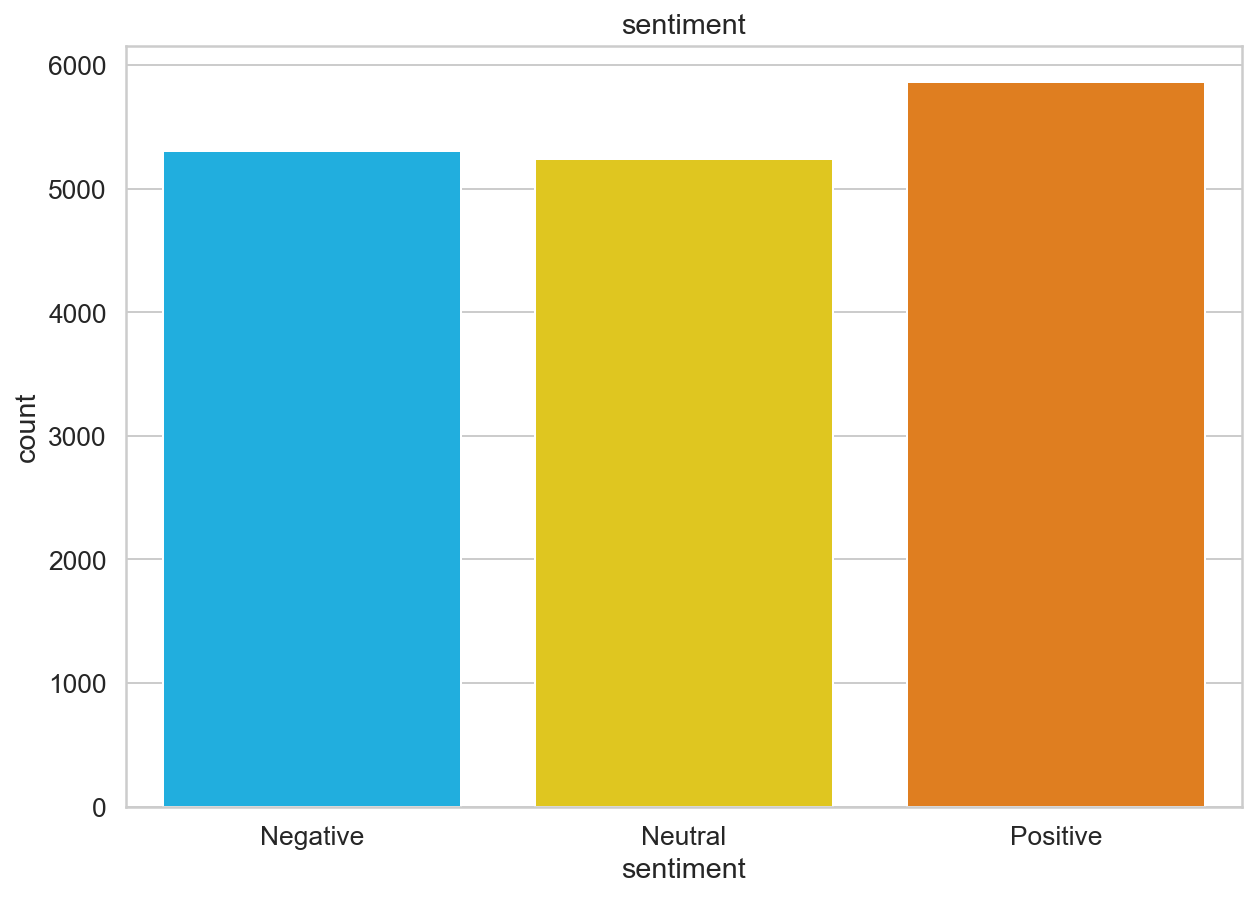

In [ ]:
plt.figure(figsize=fig_size)
sns.countplot(reviews_df['sentiment'])
plt.xticks([0, 1, 2],['Negative','Neutral','Positive'])
plt.title('sentiment')
plt.show()

Finally we can see the balanced dataset.

### Prepare training , validation  data
--> convert reviews into tokens
--> convert tokens into token ids
--> set max len
--> creating padding
--> all this will done by tokenizer.encode_plus

### Tokenizer

I have explained BERT Tokenizer in detail in my previous [blog](https://niteshkumardew11.medium.com/implementing-bert-for-question-and-answer-67ccd0e8aae5) and you can visit this blog to know about BERT Tokenizer in depth.

Let's talk about what type of input that BERT model expect. Both BERT-base and BERT-large models are pre trained on a large amount of data set and this pre-training is done based one two processes, The first one is Masked Language Model and other is Next sentence prediction model. So by default model expects two sequences(sentences) of inputs, In task like question and answering first sequence is passage and second one is question but here in our case it is a classification task and we have only one sequence as input.

We need to provide an additional attention mask to tell the model that we have only one sequence of input.

I recommend the readers to please visit my another [blog](https://niteshkumardew11.medium.com/implementing-bert-for-question-and-answer-67ccd0e8aae5) where I have explained BERT tokens, token ids , special tokens and segment ids (attension mask) in detail.
  


### Input to the BERT Model
In case of training BERT model for sentiment analysis(Classification), the model expects two inputs, token ids and attention mask and best part is we don't have to do dirty work as hugging face library provides many functions to do this dirty work for us.

token ids : it is an integer that represents a particular token.

attention mask : it is a sequence of ones and zeroes to tell the model which token comes from input sentence (segment id =1) and which are just padding token(segment id =0).

padding : when we train BERT model we make sure that every input to the model should have same size that means same length of inputs so that the model can perform back propagation efficiently but all our input which are review text can not be in same size, some can be small review and some can be large. Padding is the technique where we make our entire review in the same size but first we have to decide a fixed length or max_length. If we assign this max length with small value then model training will be fast but we might lose a lot of information and on other hand if we assign it with large value then we will be holding all the review information but training will become very slow. 

Any input with token length less than max length is padded up to max length and inputs with token length greater than max length are truncated from its ends.



Let's first see how the BERT tokenizer converts sentences into token ids.

In [ ]:
bert_model_name = 'bert-base-cased'
tokenizer = transformers.BertTokenizer.from_pretrained(bert_model_name)

sample_text = "originally gave this a 2 star but I think it only deserves 1. I simply can't wrap my head around the following. picture this, you add a task to your list. the reminder feature is on.you want to change the time on the reminder feature so you click it."
               
tokens = tokenizer.tokenize(sample_text)
ids = tokenizer.convert_tokens_to_ids(tokens)
print(f'{sample_text}')
print('='*60)
print(tokens)
print('='*60)
print(ids)

originally gave this a 2 star but I think it only deserves 1. I simply can't wrap my head around the following. picture this, you add a task to your list. the reminder feature is on.you want to change the time on the reminder feature so you click it.
['originally', 'gave', 'this', 'a', '2', 'star', 'but', 'I', 'think', 'it', 'only', 'deserves', '1', '.', 'I', 'simply', 'can', "'", 't', 'wrap', 'my', 'head', 'around', 'the', 'following', '.', 'picture', 'this', ',', 'you', 'add', 'a', 'task', 'to', 'your', 'list', '.', 'the', 'reminder', 'feature', 'is', 'on', '.', 'you', 'want', 'to', 'change', 'the', 'time', 'on', 'the', 'reminder', 'feature', 'so', 'you', 'click', 'it', '.']
[2034, 1522, 1142, 170, 123, 2851, 1133, 146, 1341, 1122, 1178, 18641, 122, 119, 146, 2566, 1169, 112, 189, 10561, 1139, 1246, 1213, 1103, 1378, 119, 3439, 1142, 117, 1128, 5194, 170, 4579, 1106, 1240, 2190, 119, 1103, 15656, 2672, 1110, 1113, 119, 1128, 1328, 1106, 1849, 1103, 1159, 1113, 1103, 15656, 2672, 1177

The function tokenizer.tokenize() and tokenizer.convert_tokens_to_ids() are general purpose functions and it does not convert our review compatible for training data like adding [CLS] token at beginning, padding and [SEP] token at the end.

These are some special tokens and corresponding ids.

In [ ]:
# special tokens
print(tokenizer.sep_token , tokenizer.sep_token_id)
print(tokenizer.cls_token,tokenizer.cls_token_id)
print(tokenizer.unk_token,tokenizer.unk_token_id)
print(tokenizer.pad_token,tokenizer.pad_token_id)

[SEP] 102
[CLS] 101
[UNK] 100
[PAD] 0


Hugging face library provides another function called tokenizer.encode_plus() which we will use to perform almost entire  preprocessing steps in one go. It
* converts reviews into tokens
* adds [CLS] token at the beginning of input
* performs padding if sequence length is less than max_len
* performs truncation if sequence length is greater than max_len
* adds [SEP] token at the end of sequence.

In [ ]:
encoding = tokenizer.encode_plus(
      sample_text,
      add_special_tokens=True,
      max_length=128,
      truncation=True,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt')

In [ ]:
print(encoding['input_ids'].shape)
encoding['input_ids']

torch.Size([1, 128])


tensor([[  101,  2034,  1522,  1142,   170,   123,  2851,  1133,   146,  1341,
          1122,  1178, 18641,   122,   119,   146,  2566,  1169,   112,   189,
         10561,  1139,  1246,  1213,  1103,  1378,   119,  3439,  1142,   117,
          1128,  5194,   170,  4579,  1106,  1240,  2190,   119,  1103, 15656,
          2672,  1110,  1113,   119,  1128,  1328,  1106,  1849,  1103,  1159,
          1113,  1103, 15656,  2672,  1177,  1128, 13440,  1122,   119,   102,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,  

In [ ]:
print(encoding['attention_mask'].shape)
encoding['attention_mask']

torch.Size([1, 128])


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

Above in input ids we can see that it starts with 101 which corresponds to [CLS] token and ends with 102 corresponds to [SEP] token and since our sequence length is less than max_len(128) the input_id is padded with zeros upto length = 128.

Also in the attention mask we can see all the tokens coming from reviews are assigned with id 1 and padding token assigned with id 0. 


One thing that still confuse me is attention mask make sense in task like question and answering where we have two sequence of input and the model must know which is question and which is passage and model uses attention mask to identify those sequence but task like classification where we have only one input and while generating input ids it padded with 0 ids. The id 0 is specific for padding tokens only which the model can recognize from the input id itself then why it needed an additional attention mask for such a task.
please let me know by comments if you guys have any answers for that.


### Decide max_len
The best way to decide max_len for our task is plotting a distribution graph for the number of words in each review. We will assign max_len to that value for which most of the review is covered without truncation.

In [ ]:
reviews_df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,app_id,review_status,sentiment
0,gp:AOqpTOHTeNGxl9Zhlz-BM6ybraEsnVg0BLDubF8E_fQ...,kelvin ho,https://play-lh.googleusercontent.com/-rSnBD4Y...,Very very bad experience with the management! ...,1,4,5.10.0.8,2021-02-26 09:47:49,"Hi Kelvin, we've checked our records and could...",2021-02-28 15:06:51,com.anydo,most_relevent,0
1,gp:AOqpTOH2VEhd1ldAR1zxGzjJEIa37fCBgY9S3sqe_TE...,Matt Van Der Schyff,https://play-lh.googleusercontent.com/-sMd4wLr...,originally gave this a 2 star but I think it o...,1,80,5.9.0.2,2021-02-04 11:05:28,We are unaware of any issues with setting remi...,2021-02-04 14:38:06,com.anydo,most_relevent,0
2,gp:AOqpTOH5OkwJH-nRT4nopD_JNTIYpWs1xWzOsFE-pn7...,Charles Green,https://play-lh.googleusercontent.com/a-/AOh14...,"Ugh! After years of using this app, I am so ve...",1,9,5.9.0.2,2021-02-18 00:40:03,"From checking our records, the issue you've re...",2021-02-18 16:52:00,com.anydo,most_relevent,0
3,gp:AOqpTOG4LKg25ejg1Hw1TWs6_gIXhpwJRZZpXssMygx...,Andi Tan,https://play-lh.googleusercontent.com/-vozop-l...,I'm a new user. I think this app's great. I tr...,1,12,5.9.0.2,2021-02-07 17:24:54,The Quick-add bar on the device's Notification...,2021-02-09 14:49:18,com.anydo,most_relevent,0
4,gp:AOqpTOGQ7NShvSVr9Vqz67MSeTN_3rkBuYtQRtsyAo5...,Drew Dayman,https://play-lh.googleusercontent.com/a-/AOh14...,Bought it to use with Alexa. After multiple at...,1,1,5.9.0.2,2021-02-13 02:05:18,None,NaT,com.anydo,most_relevent,0


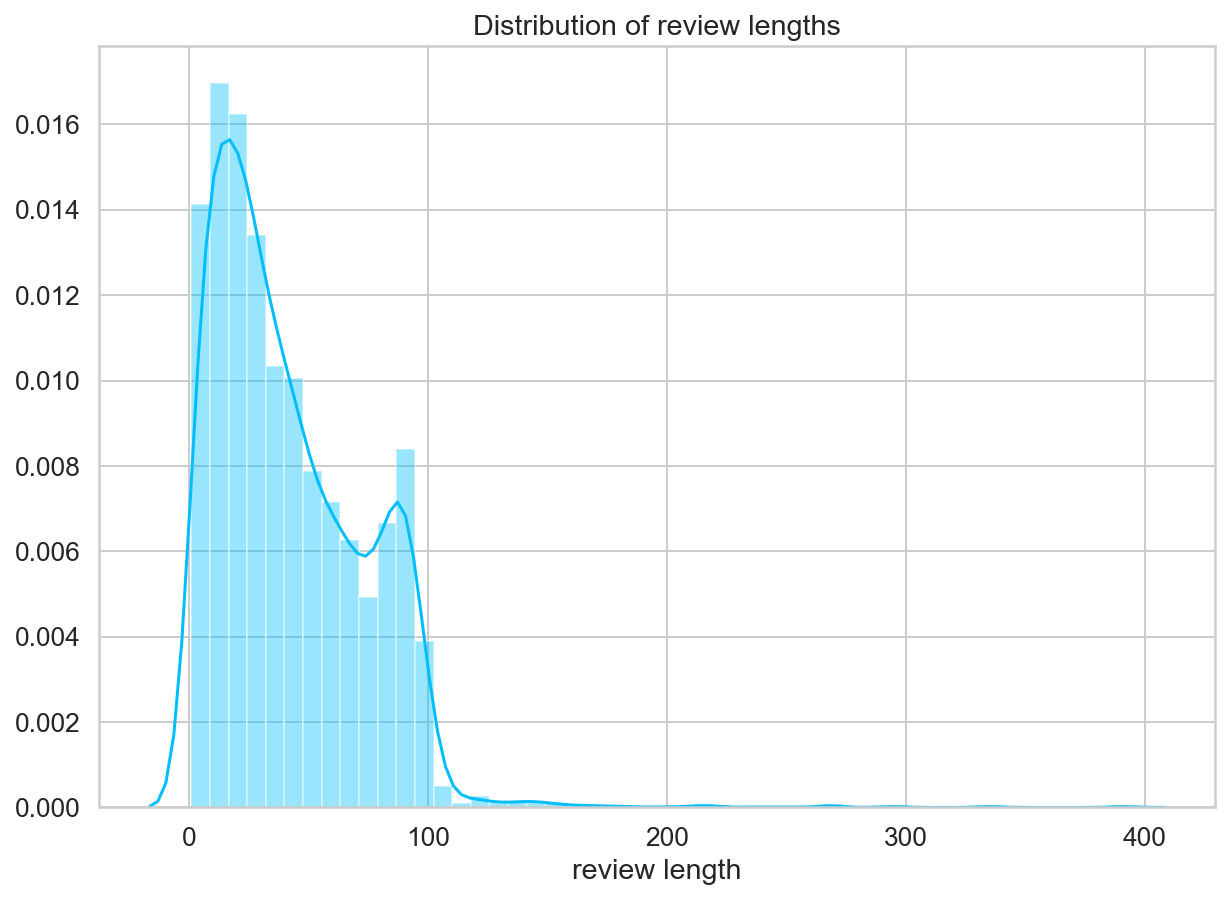

In [ ]:
# max length of sequence 

lengths = np.array([len(x.split()) for x in reviews_df.content])
plt.figure(figsize = fig_size)
sns.distplot(lengths)
plt.xlabel('review length')
plt.title('Distribution of review lengths')
plt.show()

#### optimal max len = 128 will be fine

## Training and validation data split


In [ ]:
### Train , val and test data 
from sklearn.model_selection import train_test_split

train_df , test_df  = train_test_split(reviews_df, test_size = 0.2, random_state = RANDOM_SEED, shuffle = True)
val_df , test_df  = train_test_split(test_df, test_size = 0.5, random_state = RANDOM_SEED, shuffle = True)

print(train_df.shape , test_df.shape , val_df.shape)

(13162, 13) (1646, 13) (1645, 13)


## Dataset and Dataloader

We will use pytorch for fine tuing our BERT model for Sentiment analysis and we will use pytorch module such as Dataset and Dataloader which will finally convert out data into batches.

We designed a class called GoogleAppReview which is child class of Dataset provide by pytorch and this class contains blue print for the data which will be feed to our BERT model.

In [ ]:
class GoogleAppReview(Dataset):
    def __init__(self, review, target, tokenizer, max_len):
        self.review = review
        self.target = target
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.review)
    
    def __getitem__(self,index):
        review = self.review[index]
        encoding = self.tokenizer.encode_plus(
                          review,
                          add_special_tokens=True,
                          max_length=128,
                          truncation=True,
                          return_token_type_ids=False,
                          pad_to_max_length=True,
                          return_attention_mask=True,
                          return_tensors='pt')
        
        return {'review' : review,
                'input_id': encoding['input_ids'].flatten(),
                'attention_mask':encoding['attention_mask'].flatten(),
                'target': torch.tensor(self.target[index], dtype = torch.long)
               }
        

Now we will create class variable training_data, validation_data and test_data of class GoogleAppReview.

In [ ]:
tokenizer = transformers.BertTokenizer.from_pretrained(bert_model_name)
MAX_LEN = 128

training_data = GoogleAppReview(review = train_df.content.to_numpy(),
                               target = train_df.sentiment.to_numpy(),
                               tokenizer = tokenizer,
                               max_len = MAX_LEN)

validation_data = GoogleAppReview(review = val_df.content.to_numpy(),
                               target = val_df.sentiment.to_numpy(),
                               tokenizer = tokenizer,
                               max_len = MAX_LEN)

test_data = GoogleAppReview(review = test_df.content.to_numpy(),
                               target = test_df.sentiment.to_numpy(),
                               tokenizer = tokenizer,
                               max_len = MAX_LEN)

In [ ]:
print(len(training_data),len(test_data),len(validation_data))

13156 1645 1645


Now we have decent amount of training test and validation data. Let's quickly create data loader for training test and validation data so that it can converts into batches and can be trained easily.

In [ ]:
## DataLoader
BATCH_SIZE = 16
train_loader = DataLoader(training_data , batch_size = BATCH_SIZE , shuffle = True)
test_loader = DataLoader(test_data , batch_size = BATCH_SIZE , shuffle = False)
val_loader = DataLoader(validation_data , batch_size = BATCH_SIZE , shuffle = False)

Since we have created data loader for all training test and validation data now let's check whether every thing is working fine or not.

In [ ]:
sample_batch = next(iter(train_loader))
sample_batch.keys()

dict_keys(['review', 'input_id', 'attention_mask', 'target'])

In [ ]:
print(sample_batch['review'][0])
print(sample_batch['input_id'][0])
print(sample_batch['attention_mask'][0])
print(sample_batch['target'][0])
print('='*50)
print(sample_batch['input_id'].shape,sample_batch['attention_mask'].shape,sample_batch['target'].shape)

Nice to manage time but you should work on notifications. The notifications set before time appear on time of tasks and custom tunes dont work. Apart from these, app is well made and helpful.
tensor([  101,  8835,  1106,  5494,  1159,  1133,  1128,  1431,  1250,  1113,
         1136, 25583,   119,  1109,  1136, 25583,  1383,  1196,  1159,  2845,
         1113,  1159,  1104,  8249,  1105,  8156, 17378,  1274,  1204,  1250,
          119, 10342,  1121,  1292,   117, 12647,  1110,  1218,  1189,  1105,
        14739,   119,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,

Every thing looks fine as we can see input ids and attention mask and you can check the size of sample batch = (16,128) where 16 represents batch size and 128 represents max_len. 

## Model Selection

The BERT model comes with two configurations or we can say two different sizes BERT-base and BERT-large and we haven't talked about which model we are going to select. Performance wise BERT-large is more accurate as it has more bert-layer(24) and embedding size = 1024 but it is very hard to fine tune as I do not have any powerful GPUs on other hand BERT-base comes with 12 bert-layer and 768 embedding size which is much more easy to train as compare to BERT-large and performance wise also BERT-base give reasonably good performance.

By considering all those factors I will use BERT-base for our sentiment analysis model.


## Loading BERT-base model

In [ ]:
# Load BERT base model

bert_model_name = 'bert-base-cased'
bert_model = BertModel.from_pretrained(bert_model_name)


## testing the output of bert model
x = bert_model(sample_batch['input_id'].view(BATCH_SIZE,MAX_LEN)
               ,sample_batch['attention_mask'].view(BATCH_SIZE,MAX_LEN))

print('Last hidden layer size for input as batch',x[0].shape)
print('Pooled output size for input as batch',x[1].shape)

Last hidden layer size for input as batch torch.Size([16, 128, 768])
Pooled output size for input as batch torch.Size([16, 768])


The reader can visit my another [blog](https://niteshkumardew11.medium.com/implementing-bert-for-question-and-answer-67ccd0e8aae5) where I have described the BERT outputs in detail.

## Model Architecture

We will add one more linear layer on top of the BERT-base model which takes inputs from a pooled layer of BERT base and generates 3D output for each input. These three outputs will indicate the chance of a review to its respective sentiments where First output represents Negative and second and third output represents Neutral and positive respectively.




In [ ]:
## build model 
# input to the model -->review ids and attention mask

class SentimentClassifier(nn.Module):
    def __init__(self,num_classes):
        super(SentimentClassifier,self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.dropout = nn.Dropout(p = 0.3)
        self.linear = nn.Linear(self.bert.config.hidden_size,num_classes)
        self.softmax = nn.Softmax(dim = 1)
        
    def forward(self,input_ids , attention_mask):
        temp = self.bert(input_ids,attention_mask) # Here we have added one linear layer on top of 
        pooled_output = temp[1]                    # BERT-base with number of output = 3 
        out = self.dropout(pooled_output)          # 
        out = self.linear(out)
        return out

Above model takes a batch as input and linear layer as (size = 3) as output, to get the final output we must apply softmax at the end. Let's check with a sample batch.

In [ ]:
num_classes = 3
model = SentimentClassifier(num_classes)

sample_linear_output = model(sample_batch['input_id']
                             ,sample_batch['attention_mask'])

s = nn.Softmax(dim=1)
final_out = s(sample_linear_output)
final_out

tensor([[0.2911, 0.4083, 0.3006],
        [0.3175, 0.3613, 0.3212],
        [0.3113, 0.4181, 0.2706],
        [0.3120, 0.3790, 0.3090],
        [0.2922, 0.4710, 0.2368],
        [0.3276, 0.4859, 0.1865],
        [0.1630, 0.4745, 0.3625],
        [0.3412, 0.3262, 0.3326],
        [0.2923, 0.3754, 0.3323],
        [0.4209, 0.3261, 0.2530],
        [0.2505, 0.3839, 0.3656],
        [0.3679, 0.4257, 0.2064],
        [0.1804, 0.5219, 0.2977],
        [0.2110, 0.3943, 0.3947],
        [0.1732, 0.3781, 0.4487],
        [0.3708, 0.3911, 0.2381]], grad_fn=<SoftmaxBackward>)

Till now everything looks fine. We got output(16,3) for the sample batch where 16 is sample size and 3 is number of outputs for each input. 


The following initial steps are performed to train any deep learning model using pytorch which are
* define loss function
* define optimizer
* define scheduler (it will modify learning rate after each iteration that speed-up the convergence. using it is optional but recommended)



In [ ]:
## loss and optimizer
learning_rate = 1e-5
EPOCHS = 20
total_steps = len(train_loader) * EPOCHS

criterian = torch.nn.CrossEntropyLoss()

optimizer = transformers.AdamW(params = model.parameters(),lr = learning_rate, correct_bias= False)

scheduler = transformers.get_linear_schedule_with_warmup(optimizer = optimizer,
                                                        num_warmup_steps = 0,
                                                        num_training_steps = total_steps)

Below function trains model (forward pass and backward pass) for one epoch and also calculate accuracy and average loss for an epoch.

In [ ]:
def train_model(model, data_loader, criterian, optimizer, scheduler, BATCH_SIZE ,MAX_LEN, n_examples):
    
    model.train()
    train_loss = []
    correct_pred = 0
    
    for d in data_loader:
        input_ids = d['input_id']
        attention_masks = d['attention_mask']
        targets = d['target']

        # forward prop
        predictions = model(input_ids , attention_masks)
        loss = criterian(predictions, targets)
        _,pred_classes = torch.max(predictions, dim=1)
        #backprop
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # hack to avoid gradient explotion
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        # training loss and number of correct prediction
        train_loss.append(loss.item())
        correct_pred += torch.sum(pred_classes==targets)
    return correct_pred / n_examples , np.mean(train_loss)

This fuction evaluate model performance on evaluation data for every epoch by calculation accuracy and average loss. 

In [ ]:
def eval_model(model, data_loader, criterian, BATCH_SIZE ,MAX_LEN, n_examples):
    model.eval()  # to make model in evaluastion model , Dropout will not apply 
    eval_loss = []
    correct_pred = 0
    
    with torch.no_grad():  # calculation of gradient is not required on evaluation
        for d in data_loader:
            input_ids = d['input_id']
            attention_masks = d['attention_mask']
            targets = d['target']

            # forward prop
            predictions = model(input_ids , attention_masks)
            loss = criterian(predictions, targets)
            _,pred_classes = torch.max(predictions, dim=1)

            eval_loss.append(loss.item())
            correct_pred += torch.sum(pred_classes==targets)
    return correct_pred / n_examples , np.mean(eval_loss)

In this loop we are calling functions train_model() and eval_model() and printing the accuracy and loss for both training and validation data for every epoch and also saving the model if model performance on validation data improves than previous epoch.

The way I printed epochs ,loss and accuracy might feel you as you are training model in Keras framework.

Training this model in my local system took a lot of time as I didn't have any GPU installed. I used google colab only for training purpose which you can find [here](https://colab.research.google.com/drive/1gIHdpaf4V6ZIxu8PsPrjE8Q9gVuzyd0u?authuser=0)

In [ ]:

from collections import defaultdict

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    
    # training part 
    
    print(f'epoch : {epoch+1}/{EPOCHS}')
    model = SentimentClassifier(num_classes)
    train_acc , train_loss = train_model(model,
                                         train_loader,
                                         criterian,
                                         optimizer, 
                                         scheduler, 
                                         BATCH_SIZE,
                                         MAX_LEN,
                                         len(train_df))
    # validation part
    
    val_acc , val_loss = eval_model(model, 
                                    val_loader,
                                    criterian,
                                    BATCH_SIZE,
                                    MAX_LEN, len(val_df))
    
    # saving training logs
    
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    
    print(f'train_loss: {train_loss}, train_acc: {train_acc} ,val_loss: {val_loss}, val_acc: {val_acc}')
    
    # saving model if performance improved 
    
    if val_acc > best_accuracy:
        best_model_name = f'best_model_state_{val_acc}.bin'
        torch.save(model.state_dict(), best_model_name)
        best_accuracy = val_acc


< add image from colab of training logs>

Loading model fine tuned on google colab

In [ ]:
## model has been trained on google colab
num_classes = 3
model = SentimentClassifier(num_classes)
model.load_state_dict(torch.load('models/best_model_state.bin',map_location=torch.device('cpu')))

<All keys matched successfully>

## Evaluation Fianl model on Test data

In [ ]:
def get_predictions(model, data_loader):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in tqdm(data_loader):

            texts = d["review"]
            input_ids = d["input_id"]
            attention_mask = d["attention_mask"]
            targets = d["target"]

            outputs = model(input_ids=input_ids,
                            attention_mask=attention_mask)
            
            _, preds = torch.max(outputs, dim=1)

            probs = F.softmax(outputs, dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return review_texts, predictions, prediction_probs, real_values

In [ ]:
from tqdm import tqdm
import torch.nn.functional as F
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model,test_loader)

100%|██████████| 103/103 [08:11<00:00,  4.77s/it]


In [ ]:
from sklearn.metrics import classification_report

class_names = ['negative', 'neutral', 'positive']
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.96      0.94      0.95       567
     neutral       0.89      0.90      0.90       498
    positive       0.94      0.94      0.94       581

    accuracy                           0.93      1646
   macro avg       0.93      0.93      0.93      1646
weighted avg       0.93      0.93      0.93      1646



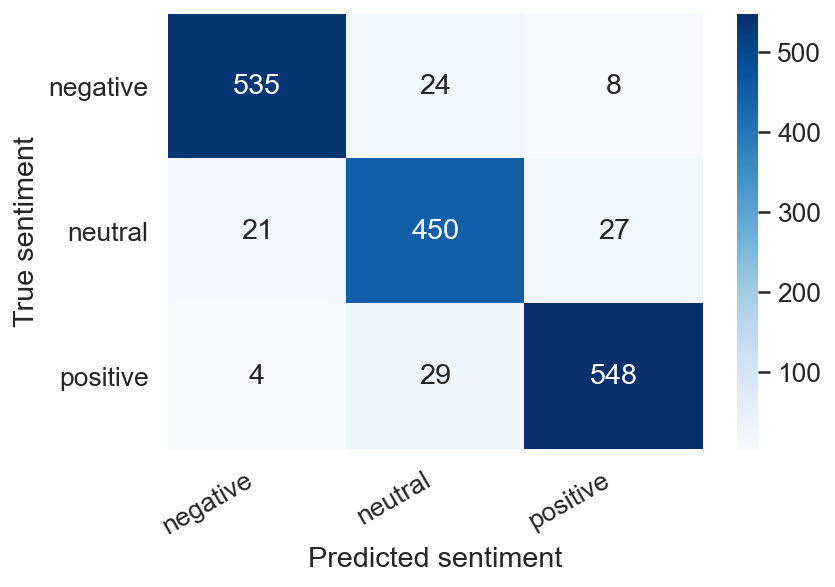

In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

### Testing model performance on unseen  data

In [ ]:
### Predicting on Raw text data

def get_sentiment(sample_review):
    # get input ids and attention mask
    encode_sample_review = tokenizer.encode_plus(
                              sample_review,
                              add_special_tokens=True,
                              max_length=128,
                              truncation=True,
                              return_token_type_ids=False,
                              pad_to_max_length=True,
                              return_attention_mask=True,
                              return_tensors='pt')

    input_ids = encode_sample_review['input_ids']
    attention_mask = encode_sample_review['attention_mask']
    # predict output
    output = model(input_ids, attention_mask)
    _, prediction = torch.max(output, dim=1)
    # output as probabilities
    pred_probs = F.softmax(output,dim=1).detach().numpy().reshape(3)
    
    class_names = ['negative', 'neutral', 'positive']
    data = {'class_names':class_names, 
            'value':pred_probs} 

    # Create DataFrame 
    df = pd.DataFrame(data)
    # plot bars for probability of each sentiment
    sns.barplot(x='value', y='class_names', data=df, orient='h')
    plt.ylabel('sentiment')
    plt.xlabel('probability')
    plt.xlim([0, 1]);
    print(f'Review text: {sample_review}')
    print('=*'*50)

    print(f'negative % : {pred_probs[0]:.4f}, neutral % : {pred_probs[1]:.4f}, positive % : {pred_probs[2]:.4f}')

    print(f'Sentiment  : {class_names[prediction]}')



Review text: I would have gave it 5 stars, but it was kind of weird, because when I tried to exit the game, it kept pulling me back inside of it, but I did not want that to happen, so I went to app store, I had to reset my phone, but it's still worth. I had to go to app store and I have to give me a one song because. Filled star wrong.anyway, I spelled that wrong too even star. I gave it one star because it was kind of creepy. He was following my finger, I got really scared, so I had to exit the game and gav
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
negative % : 0.0001, neutral % : 0.9988, positive % : 0.0010
Sentiment  : neutral


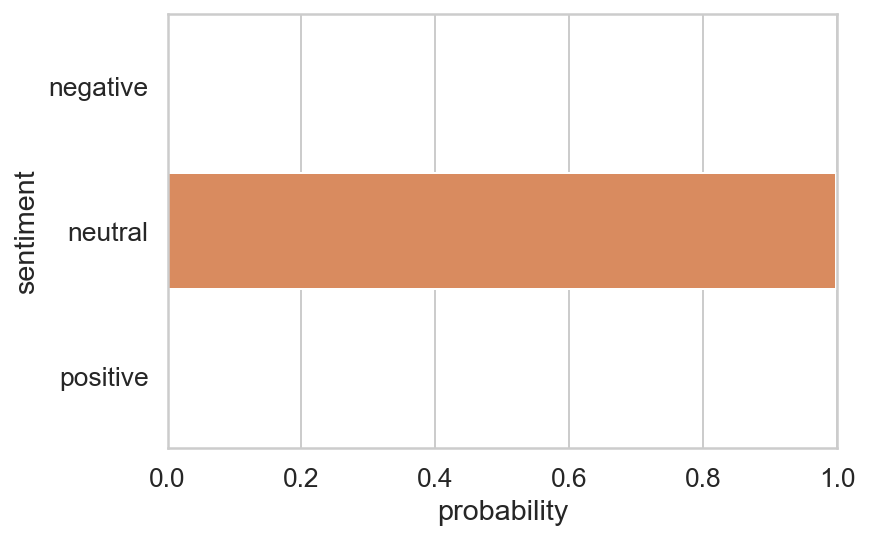

In [ ]:
sample_review = "I would have gave it 5 stars, but it was kind of weird, because when I tried to exit the game, it kept pulling me back inside of it, but I did not want that to happen, so I went to app store, I had to reset my phone, but it's still worth. I had to go to app store and I have to give me a one song because. Filled star wrong.anyway, I spelled that wrong too even star. I gave it one star because it was kind of creepy. He was following my finger, I got really scared, so I had to exit the game and gav"

get_sentiment(sample_review)